## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Komórki rekurencyjne - jednostki w których wartość wyjściowa jest podawana z powrotem na wejście. 
Wartości wyjściowe i wejściowe są obliczane w krokach "czasowych".
Wyjście z poprzedniego kroku, `i-1`, jest podawane na wejście w aktualnym kroku, `i`:

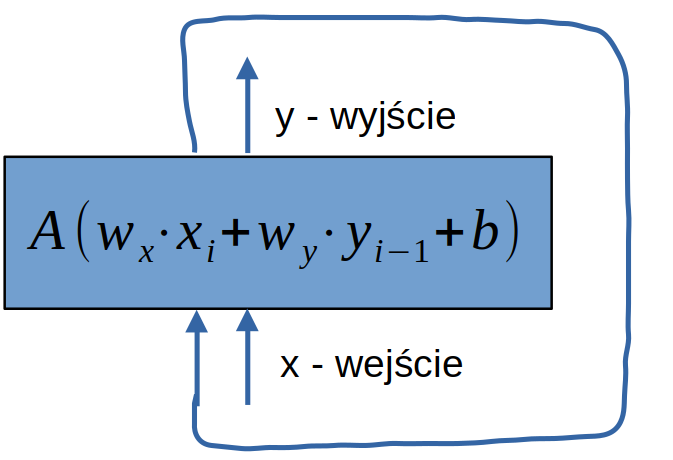

Stan neuronu w kroku `i` jest nazywany zwykle stanem ukrytym, `ang. hidden` i nie musi być on tożsamy z wartością wyjściową neuronu.
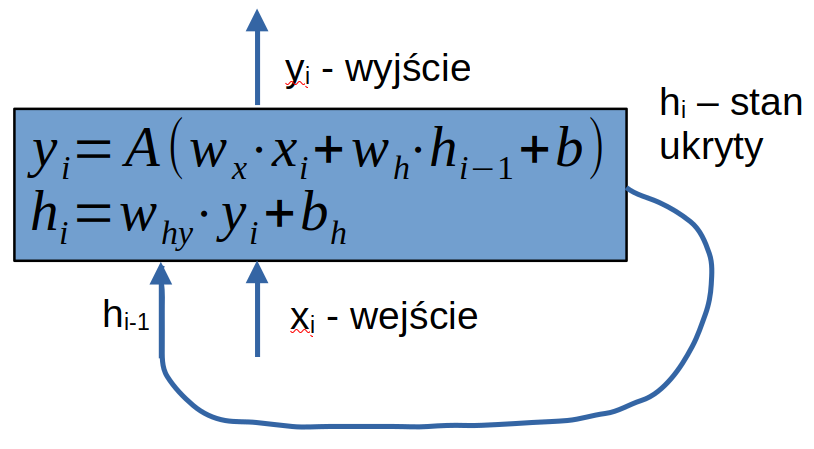

Standardowo komórki RNN przetwarzają sekwencje: 

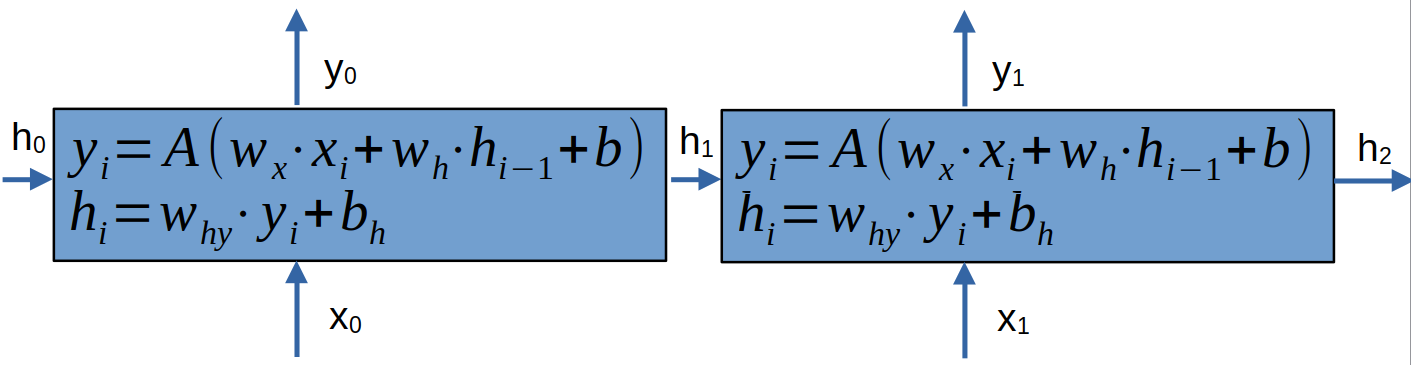

Warstwa zawierająca najprostszy wariant, **bez dodatkowego mieszania składowych stanu ukrytego,**  komórki rekurencyjnej, ang. `Recurrent Neural Network cell, RNN cell` 
jest zaimplementowana w interfejsie użytkownika Keras jako

```Python
tf.keras.layers.SimpleRNN(
    units,                              # liczba neuronów
    activation='tanh',                  # funkcja aktywacji. W RNN zwykle używa się tanh(x)
    use_bias=True,                      # czy wartwa ma używać wyrazów wolnegych?
    recurrent_initializer='orthogonal', # inicjalizacja wag mieszających składowe stanu ukrytego
    recurrent_regularizer=None,         # regularyzacja wag mieszających składowe stanu ukrytego
    dropout=0.0,                        # ułamek losowo zerowanych składowych danych wejściowych
    recurrent_dropout=0.0,              # ułamek losowo zerowanych skłądowych stanu ukrytego
    return_sequences=False,             # czy warstwa ma zwracać sekwencję wartości w kolejnych krokach?
    return_state=False,                 # czy warstwa ma zwracać stan ukryty?
    go_backwards=False,                 # czy warstwa ma przetwarzać sekwencję w odwrotnej kolejności?
)
```

In [ ]:
batchSize = 1
nTimeSteps = 3
inputDimension = 2
outputDimension = 2

input = np.random.random((batchSize, nTimeSteps, inputDimension))
simple_rnn = tf.keras.layers.SimpleRNN(outputDimension)
output = simple_rnn(input)  
print(colored("RNN cell output:","blue"), output)

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       return_sequences=True, 
                                       return_state=True)
output = simple_rnn(input)  
print(colored("RNN cell output:","blue"), output)

Badanie działania komórki RNN.

**Proszę:**

* przygotować dane wejściowe dla warstwy RNN: 
    * jedna paczka
    * sto kroków czasowych
    * kolejne liczby całkowite w każdym kroku: `(0)`, `(1)` itd.

 * wypisać na ekran dane dla pierwszych pięciu kroków i ich kształt. 
 * sprawdzić czy kształt jest poprawny: `(batchSize, nSteps, inputDim)`   

In [ ]:
#BEGIN_SOLUTION
batchSize = 1
nTimeSteps = 100
outputDimension = 1
input = np.arange(0, nTimeSteps, 1).reshape(batchSize, nTimeSteps, outputDimension)

print(colored("Input:","blue"), input[:,0:5,:])
print(colored("Input shape:","blue"), input.shape)
#END_SOLUTION
pass



**Proszę:**

* użyć własnej funkcji inicjalizującej wagi tak by komórka RNN zwracała sumę elementów w sekwencji

**Wskazówki:**
* uwaga na funkcję aktywacji


In [ ]:
try: 
    class customInitializer(tf.keras.Initializer):
        def __init__(self, kernel):
            self.kernel = kernel

        def __call__(self, shape, dtype=None, **kwargs):
            x = tf.reshape(self.kernel, shape)
            x= tf.cast(x, dtype)
            return x  
except AttributeError:
    print(colored("tf.keras.Initializer not available","red"))
    print(colored("TF version:","blue"),tf.__version__)
    pass

In [ ]:
#BEGIN_SOLUTION
inputDimension = 1
kernel_matrix = np.diag([1])
recurrent_kernel_matrix = np.diag([1])

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       activation='linear',
                                       kernel_initializer=customInitializer(kernel_matrix),
                                       recurrent_initializer=customInitializer(recurrent_kernel_matrix),
                                       #return_sequences=True, 
                                       #return_state=True
                                       )

output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
print(colored("input:","blue"), input[:,0:5,:])
print(colored("RNN cell output:","blue"), output[:,0:5])
print(colored("Sequence sum:","blue"), np.sum(input, axis=1))
#END_SOLUTION
pass


**Proszę:**

* użyć komórki RNN do generacji liczb z ciągu Fibonacciego:
$$
\huge{
F_{n} = F_{n-1} + F_{n-2}, F_{0} = 0, F_{1} = 1
}
$$

**Wskazówka:**
* komórka powinna przyjmować ciąg dwu poprzednich elementów
* generacja kolejnych elementów powinna się odbywać w pętli


In [ ]:
#BEGIN_SOLUTION
nTimeSteps = 2
input = np.array([0,1]).reshape(batchSize, nTimeSteps, outputDimension)

for i in range(0,10):
    output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
    input = np.roll(input, 1, axis=1)
    input[:,-1,:] = output[0,0]
    print(colored("Fibnacci numer:","blue"), output[0,0].numpy())
#END_SOLUTION
pass    


Komórka RNN ma pewną wadę: wyjście jest średnią ważoną wejścia i stanu z poprzedniego kroku. To oznacza, że dane z odległych kroków w przeszłości mają mały wpływ na stan komórki w bieżącym kroku - komórka ma jedynie pamięć krótkotrwałą. Rozwiązaniem tego problemu jest wyposażenie komórki w dodatkowy stan ukryty, który może przechowywać dane w długim kresie czasu - pamięć długotrwałą. Komórka ma więc dwa rodzaje pamięci - krótko- i długo-trwałą, ang. `Long Short-Term Memory, LSTM`.




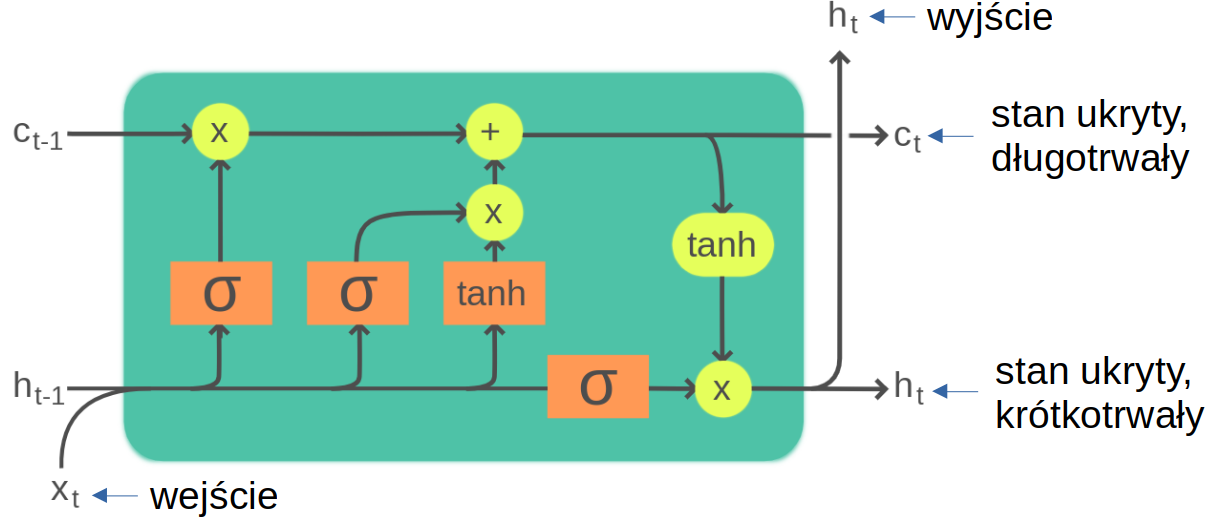

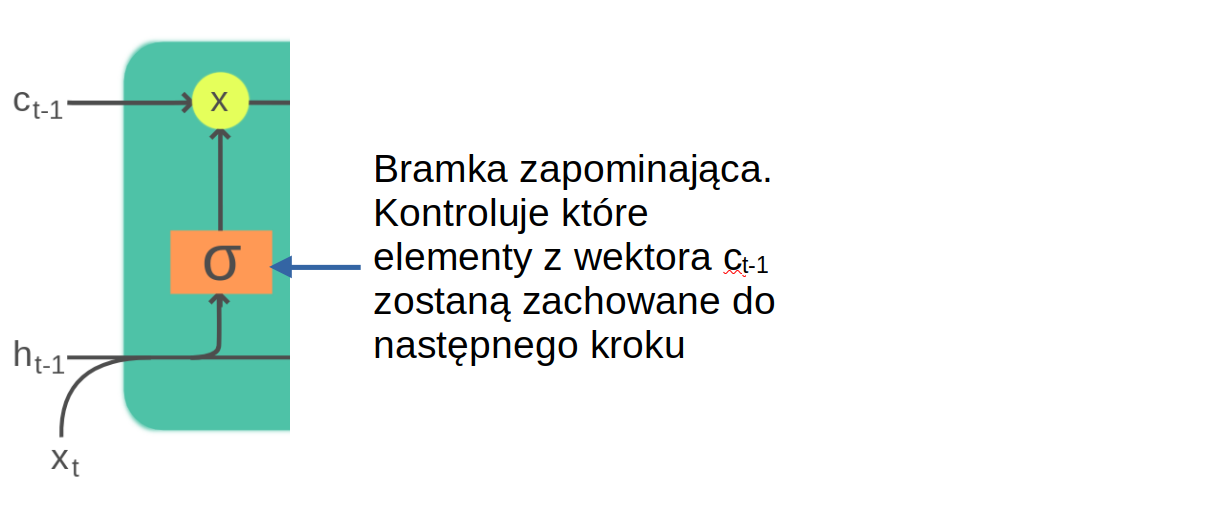

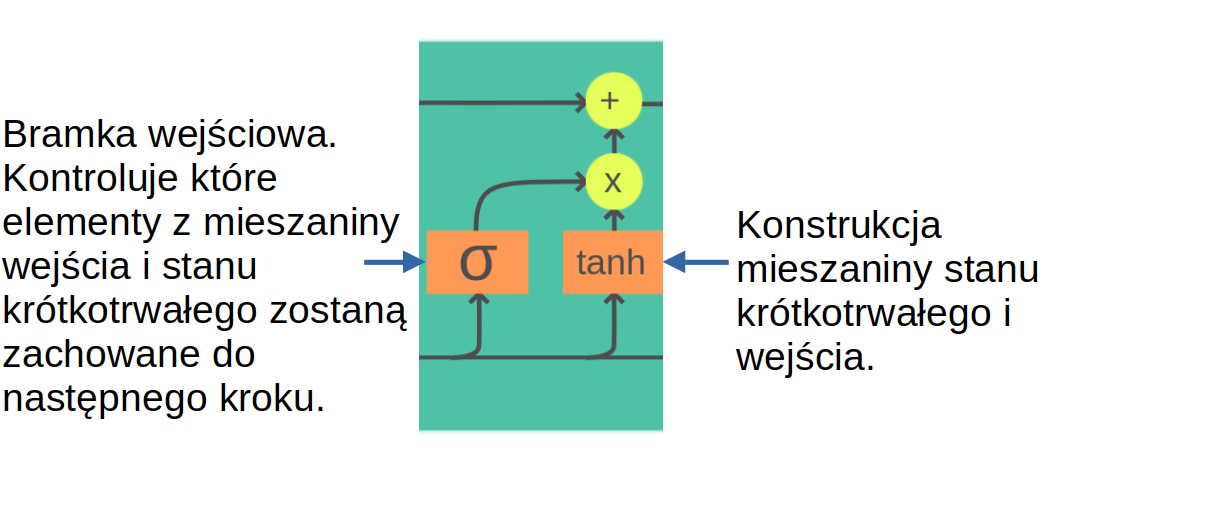

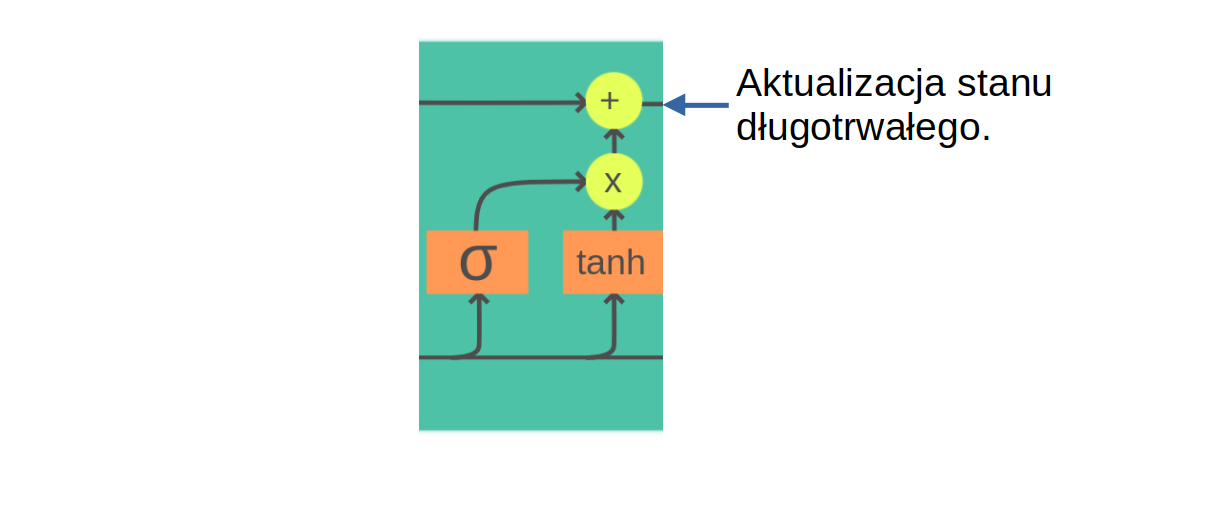

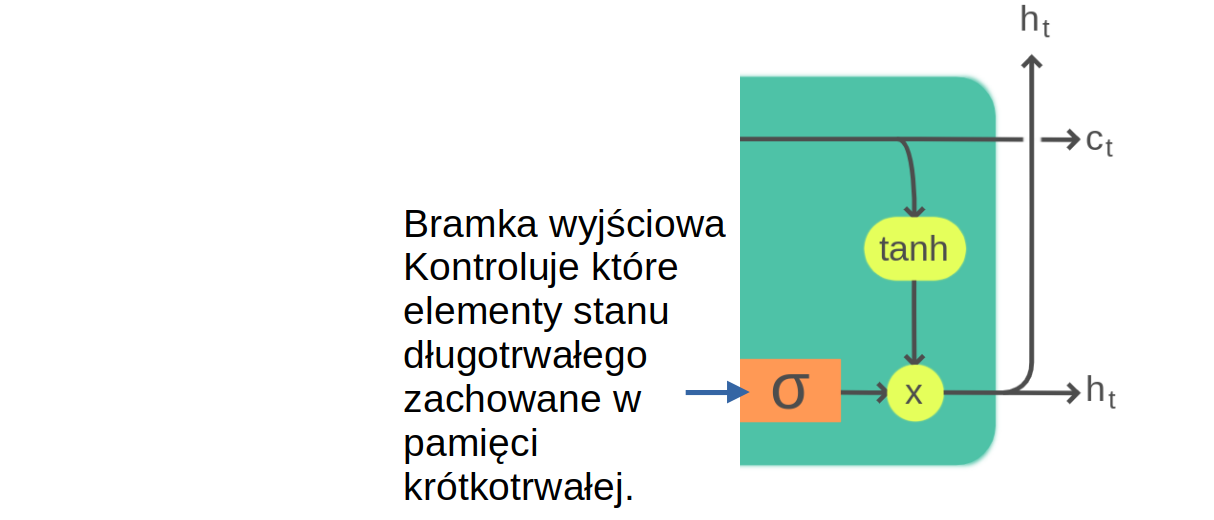

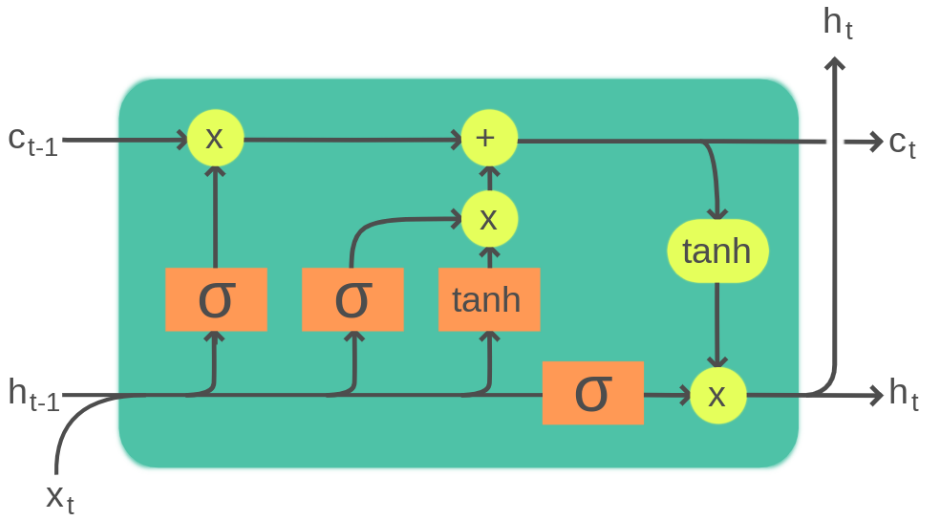

Implementacja komórki LSTM w Keras:
```Python
tf.keras.layers.LSTMCell(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    **kwargs
)
```

**Proszę:**

* napisać funkcję `generateFibonacci(n)` która generuje pierwszych `n` elementów ciągu Fibonacciego:
* stworzyć macierz `fib_sequence` zawierającą pierwsze `30` elementów ciągu Fibonacciego
* podzielić listę na fragmenty o długości `window_size=3` używając ruchomego okna z krokiem `1`.
* wypisać na ekran oryginalną i podzieloną listę

**Wskazówka:**

* do podziału listy na fragmenty można użyć funkcji `tf_text.sliding_window`

In [ ]:
#BEGIN_SOLUTION
fib = [0, 1]

def generateFibonacci(n=30):
    while len(fib) < n:
        fib.append(fib[-1] + fib[-2])
        yield fib[-1]

fib_sequence = np.array([x for x in generateFibonacci()])

window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

print(colored("Fibonacci sequence:","blue"), fib)
print(colored("Fibonacci sequence split into windows:","blue"), slidingWindowWithWidth(fib))
#END_SOLUTION
pass


**Proszę:**

* stworzyć obiekt `tf.data.Dataset` którego elementami są trójki kolejnych elementów ciągu Fibonacciego
* przetworzyć wiersze w danych do postaci `(features, label)`  gdzie  `label` to ostatni element grupy, a `features` to pozostałe
* zadbać by cechy miały kształt oczekiwany przez warstwy rekurencyjne: `(nSteps, inputDim)`
* wypisać na ekran pierwsze cztery wiersze danych

In [ ]:
#BEGIN_SOLUTION
dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(fib))
dataset = dataset.map(lambda x: tf.reshape(x, (window_size, 1))).map(lambda y: (y[:-1,:], y[-1,0])).batch(1).cache()  
 
for item in dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]) 
#END_SOLUTION
pass    


Model sekwencyjny z komórkami RNN:
```Python
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),  # kształt danych wejściowych: (liczba kroków, wymiar danych w kroku
        tf.keras.layers.LSTM(nUnits)                                                # liczba kroków nie jest znana z góry, dlatego dajemy None
model.summary()
```

In [ ]:
nUnits = 10
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
                                      tf.keras.layers.LSTM(nUnits)])  
model.summary()

**Proszę:**

* zbudować i wytrenować model z komórką RSTM który przewidzi następny element ciągu Fibonacciego na podstawie podanego ciągu - niekoniecznie dwuelementowego

**Wskazówka:**
* jak funkcja aktywacji jest odpowiednia dla wyjścia o wartości nieograniczonej z góry?

In [ ]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation='linear',  
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1))],
                            name="fib_generator")  
#model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*100,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mse', metrics=[])

history = model.fit(dataset,
                    validation_data=dataset,
                    epochs=500, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass  

**Proszę:**

* wypisać na ekran etykiety i efekt działania modelu
* narysować panel z dwoma rysunkami:
   * X=model,  Y=etykieta
   * X=numer elementu, Y=model/etykieta

In [ ]:
predictions = model.predict(dataset)[:,0].astype(int)
labels = fib_sequence[window_size-3:]

for label, prediction in zip(labels, predictions):
    print(colored("Label, prediction:","blue"), label, prediction)

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes[0].plot(labels, predictions, 'o')
axes[0].plot([0,max(labels)], [0,max(labels)], 'r')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Prediction")

axes[1].plot(predictions/labels, 'o')
axes[1].plot([0,len(labels)], [1,1], 'r')
axes[1].set_xlabel("Prediction/Label")
axes[1].set_ylim([0.5,1.5])
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)

**Proszę:**

* podać na wejście modelu ciąg 
```
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
```
* podać ten sam ciąg, **pomijając pierwszy element**
* w obu przypadkach porównać wynik modelu z wartością oczekiwaną dla elementów ciągu Fibbonaciego

In [ ]:
#BEGIN_SOLUTION
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
print(colored("Data:","blue"), data[0,:,0])
print(colored("Prediction:","blue"),model.predict(data)[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,1:,0])
print(colored("Prediction:","blue"),model.predict(data[:,1:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])
#END_SOLUTION
pass

## Rowery Kraków

**Zagadnienie:** przewidzieć liczbę rowerzystów na wybranej ulicy Krakowa na podstawie zliczeń z `window_size-1` poprzednich dni.

**Proszę:**

* pobrać dane używając komórki poniżej
* wypisać na ekran podsumowanie danych 

In [ ]:
import pandas as pd

file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWNYLoE3k3JegSt47hV66v5j7_Vh8jIdLRUhcMLrIAW4VcIZK-3W9rGoDSfnToUnCIb9DPngGAlgL6/pub?gid=0&single=true&output=csv'
df = pd.read_csv(file_url)

df = pd.read_csv(file_url, sep=",",parse_dates=[0])
df = df.rename(columns={' ' : "Data"})
df = df.fillna(0)
#BEGIN_SOLUTION
print(df.describe())
#END_SOLUTION
pass

**Proszę:**

* zidentyfikowac dwie ulice o największym średnim natężeniu ruchu
* zachować nazwy tych ulic w zmiennych `train_street` i `val_street`

In [ ]:
#BEGIN_SOLUTION
train_street = "Mogilska"
val_street = "Kotlarska"
#END_SOLUTION
pass

**Proszę:**

* na oddzielnych panelach narysować zliczenia rowerzystów w funkcji danych dla obu ulic

In [ ]:
#BEGIN_SOLUTION
fig, axes = plt.subplots(1,2, figsize=(15,4))

axes[0].plot(df["Data"], df[train_street], 'o', label=train_street);
axes[1].plot(df["Data"], df[val_street], 'go', label=val_street);
axes[0].legend()
axes[1].legend()
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15)
#END_SOLUTION
pass


**Proszę:**

* przygotować zbiory `train_dataset` i `val_dataset` zawierające dane z odpowiednich ulic
* znormalizować zliczenia czynnikiem `1/10_1000`
* przetworzyć zbiory do postaci ciągów zliczeń z `window_size` dni.
* ustawić kształt wierszy w danych na `(window_size, 1)`
* podzielić wiersze na `etykiety`: zliczenia z ostatniego dnia i `cechy`: pozostałe zliczenia
* podzielić zbiór na paczki o rozmiarze `16` i zachować go w pamięci podręcznej
* wypisać na ekran cztery przykłady ze zbioru treningowego

**Wskazówka:**
* macierz danych z kolumny zbioru pandas można wyłuskać jako `df.values`
* macierze importujemy do `tf.data.Dataset` używając metody `from_tensor_slices(...)`

In [41]:
#BEGIN_SOLUTION
window_size = 11
scale = 10_000
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)
train_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[train_street].values/scale))
train_dataset = train_dataset.map(lambda x: tf.reshape(x, (window_size, 1))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()  

val_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[val_street].values/scale))
val_dataset = val_dataset.map(lambda x: tf.reshape(x, (window_size, 1))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()

for item in train_dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0]*scale, end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]*scale)
#END_SOLUTION
pass

Features: [ 907.  438.  549. 1501. 1626. 1555. 1270.  906.  385.  246.] Labels: [804.]
Features: [291. 734. 757. 803. 839. 812. 385. 231. 612. 788.] Labels: [697.]
Features: [788. 759. 702. 456.  95.  43.  93. 317. 525. 552.] Labels: [495.]
Features: [369.  60.  55.  86. 326. 387. 366. 394. 479. 191.] Labels: [125.]


2024-05-10 13:49:17.946901: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-10 13:49:17.947309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* zbudować model z warstwami LSTM:
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca tylko ostatni element sekwencji
    * warstwa gęsta, `1` neuron
* wypisać na ekran podsumowanie modelu    

In [ ]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid')],
                         name="traffic_prediction")  
model.summary()
#END_SOLUTION
pass

**Proszę:**

* przeprowadzić trening modelu przez `150` epok Trening powinien zawierać standardowe elementy:
    * harmonogram zmiany współczynnika uczenia
    * wywołanie wczesnego zatrzymania (sprawdzić wyniki bez zatrzymania)
    * rysowane historii funkcji straty


In [ ]:
#BEGIN_SOLUTION
initial_learning_rate = 1E-3
nStepsPerEpoch = train_dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*100,
                decay_rate=0.95,
                staircase=False)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)
callbacks = [early_stop_callback]              

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mse', metrics=[])

history = model.fit(train_dataset, 
                    validation_data=val_dataset,
                    callbacks=callbacks,
                    epochs=100, verbose=0)
model.evaluate(train_dataset)
model.evaluate(val_dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass

**Proszę:**

Zrobić rysunki kontrolne na polu `(2,3)` dla każdej ulicy w wierszu:

* liczba zliczeń rzeczywista i prognozowana
* iloraz `rzeczywista/prognozowana`
* histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`
* dla ulicy użytą do trenowania proszę narysować histogram `(rzeczywista-prognozowana)/rzeczywista` dla modelu prognozowania naiwnego: "jutro będzie tak jak dziś"


NameError: name 'window_size' is not defined

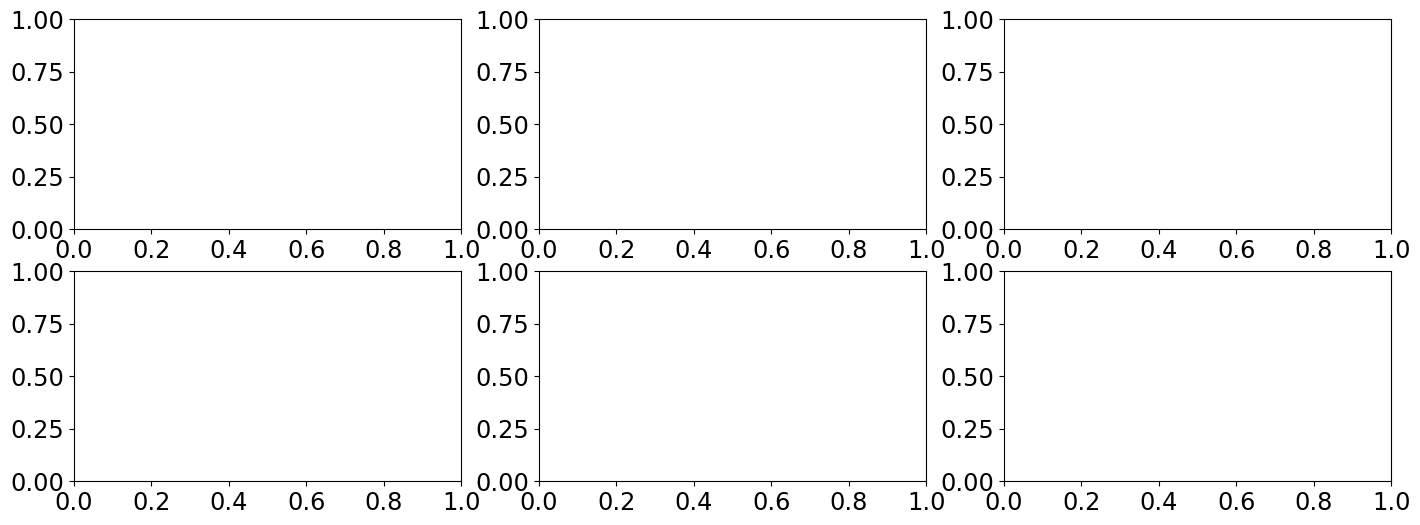

In [35]:
fig, axes = plt.subplots(2,3, figsize=(17,6))
import datetime
import matplotlib.dates as mdates
#BEGIN_SOLUTION
date = df["Data"][window_size-1:]
y = df[train_street][window_size-1:].values
y_pred = model.predict(train_dataset)[:,0]*scale
y_pred_naive = np.roll(y,1)

##
axes[0,1].set_title(train_street)
axes[0,0].plot(date, y, 'o', label="true");
axes[0,0].plot(date, y_pred, 'go', label="model");
axes[0,0].legend()
axes[0,0].set_xlim([datetime.date(2019, 12, 1), datetime.date(2021, 1, 31)])
axes[0,0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
axes[0,0].xaxis.set_minor_locator(mdates.MonthLocator())

##
axes[0,1].plot(date, y/y_pred, 'o', label="true/model");
axes[0,1].plot([date.min(), date.max()], [1,1], 'r')
axes[0,1].legend()
axes[0,1].set_ylim([-2,3])
axes[0,1].xaxis.set_major_locator(mdates.YearLocator(2, 1))
##
axes[0,2].hist((y-y_pred)/y, label="RNN", bins=np.linspace(-2,2,50));
axes[0,2].hist((y-y_pred_naive)/y, label="naive", bins=np.linspace(-2,2,50), alpha=0.7);
axes[0,2].set_xlabel = r"$\frac{true-model}{true}$"
axes[0,2].legend()
##
y = df[val_street][window_size-1:]
y_pred = model.predict(val_dataset)[:,0]*scale
y_pred_naive = np.roll(y,1)

axes[1,1].set_title(val_street) 
axes[1,0].plot(date, y, 'o', label="true");
axes[1,0].plot(date, y+np.sqrt(y), 'ob', label=r"+\sigma");
axes[1,0].plot(date, y-np.sqrt(y), 'ob', label=r"-\sigma");
axes[1,0].plot(date, y_pred, 'go', label="model");
axes[1,0].legend()
axes[1,0].set_xlim([datetime.date(2019, 12, 1), datetime.date(2021, 1, 31)])
axes[1,0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
axes[1,0].xaxis.set_minor_locator(mdates.MonthLocator())
##
axes[1,1].plot(date, y/y_pred, 'o', label="true/model");
axes[1,1].plot([date.min(), date.max()], [1,1], 'r')
axes[1,1].legend()
axes[1,1].set_ylim([-2,3])
axes[1,1].xaxis.set_major_locator(mdates.YearLocator(2, 1))
##
axes[1,2].hist((y-y_pred)/y, label=r"$\frac{true-model}{true}$", bins=np.linspace(-2,2,50));
axes[1,2].hist((y-y_pred_naive)/y, label="naive", bins=np.linspace(-2,2,50), alpha=0.7);
axes[1,2].set_xlabel = r"$\frac{true-model}{true}$"
axes[1,2].legend()
##
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15, hspace=0.4)
#END_SOLUTION
pass

In [34]:
! wget https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/2023/2023_566_s.zip
! unzip 2023_566_s.zip
! mv *.csv ../data/Pogoda/ 

filePath = "../data/Pogoda/s_d_t_566_2023.csv"
import pandas as pd

columns = ["Data",                          
           "Zachmurzenie", 
           "prędkość wiatru [m/s]", 
           "temperatura [°C]",
            "ciśnienie pary wodnej [hPa]",          
            "wilgotność względna [%]",             
            "ciśnienie na poziomie stacji [hPa]",    
            "ciśnienie na poziomie morza [hPa]",      
            "Suma opadu dzień  [mm]",    
            "Suma opadu noc   [mm]"]                              

df_pogoda = pd.read_csv(filePath,header=None,
                 sep=",", usecols = np.arange(2, 22),
                 parse_dates=[[2,3,4]], 
                 encoding='Latin1').dropna(axis=1)
df_pogoda.columns = columns

df_pogoda.head()


--2024-05-10 14:45:30--  https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/2023/2023_566_s.zip
Resolving danepubliczne.imgw.pl (danepubliczne.imgw.pl)... 91.220.17.226
Connecting to danepubliczne.imgw.pl (danepubliczne.imgw.pl)|91.220.17.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15256 (15K) [application/zip]
Saving to: ‘2023_566_s.zip.2’

2023_566_s.zip.2    100%[===================>]  14.90K  --.-KB/s    in 0s      

2024-05-10 14:45:30 (423 MB/s) - ‘2023_566_s.zip.2’ saved [15256/15256]

Archive:  2023_566_s.zip
  inflating: s_d_566_2023.csv        
  inflating: s_d_t_566_2023.csv      


,Data,Zachmurzenie,prędkość wiatru [m/s],temperatura [°C],ciśnienie pary wodnej [hPa],wilgotność względna [%],ciśnienie na poziomie stacji [hPa],ciśnienie na poziomie morza [hPa],Suma opadu dzień [mm],Suma opadu noc [mm]
0,2023-01-01,6.5,1.0,7.4,8.4,81.9,993.4,1023.1,0.0,0.0
1,2023-01-02,2.8,1.1,4.3,7.6,90.5,993.4,1023.4,0.0,0.0
2,2023-01-03,5.8,3.6,6.2,8.2,86.0,998.0,1027.9,0.0,0.0
3,2023-01-04,5.5,2.5,3.3,6.5,83.6,995.2,1025.3,0.1,1.1
4,2023-01-05,7.1,8.3,7.8,8.7,82.3,983.0,1012.3,4.9,0.4


# Zadanie domowe

**Proszę:**

* wygenerować prognozę liczby rowerzystów na ulicy `Bulwary` dla całego roku 2023
* narysować panel z trzema rysunkami: 
    * liczba zliczeń rzeczywista i prognozowana
    * iloraz `rzeczywista/prognozowana`
    * histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`


In [64]:
test_street = "Bulwary"
df = df[df["Data"]<"2024-01-01"]
df_filtered = df[df["Data"]<"2023-01-01"]

test_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df_filtered[test_street].values/scale))
test_dataset = test_dataset.map(lambda x: tf.reshape(x, (window_size, 1))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()

y = df[test_street][window_size-1:]
y_pred = model.predict(test_dataset)[:,0]*scale

for iDay in range(0, 365):
    input = y_pred[-window_size+1:].reshape(1,window_size-1,1)/scale
    y_pred = np.append(y_pred, model.predict(input, verbose=0)[0,0]*scale)
    #print(colored("Prediction:","blue"), y_pred[-1])

print(y.shape, y_pred.shape)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(2590,) (2590,)


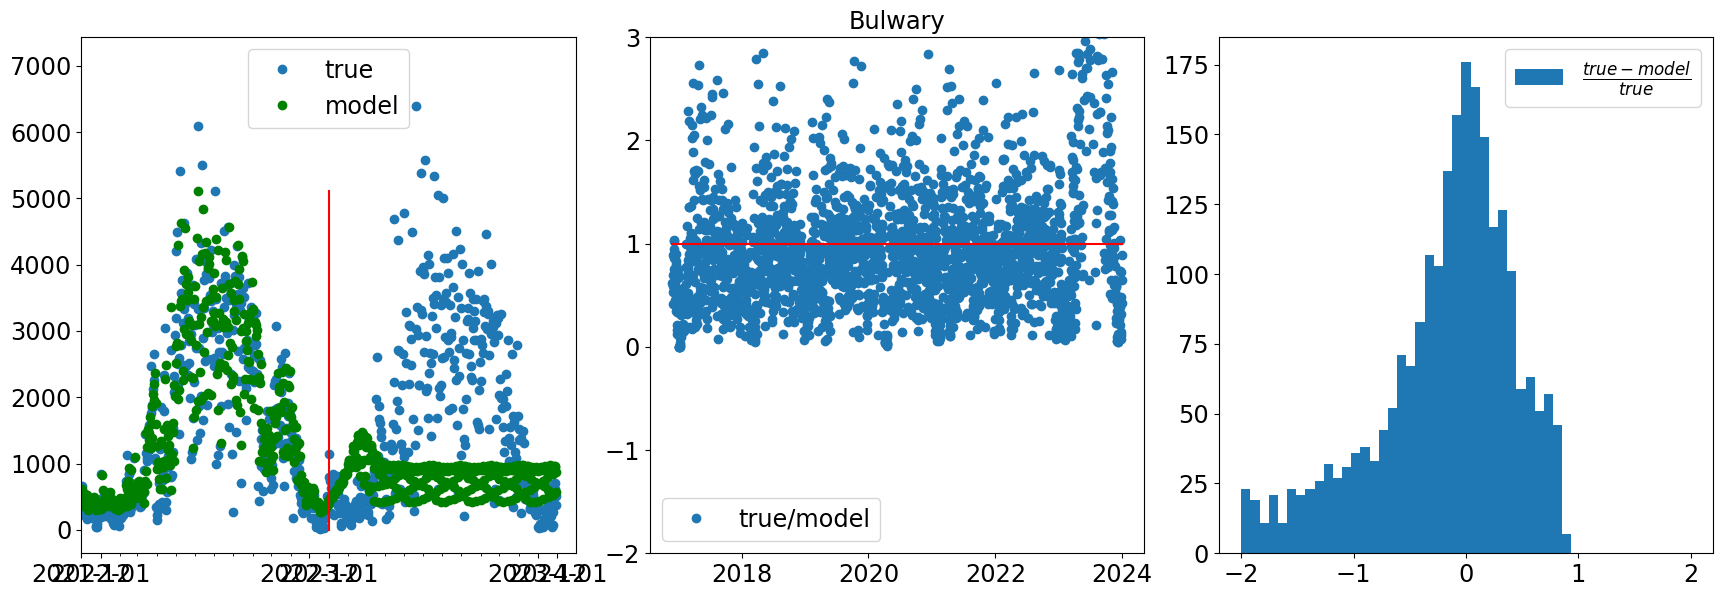

In [65]:
fig, axes = plt.subplots(1,3, figsize=(17,6))
import datetime
import matplotlib.dates as mdates
#BEGIN_SOLUTION
date = df["Data"][window_size-1:]
y = df[test_street][window_size-1:]
##
axes[1].set_title(test_street)
axes[0].plot(date, y, 'o', label="true");
axes[0].plot(date, y_pred, 'go', label="model");
#plot vertical line
axes[0].plot([datetime.date(2023, 1, 1), datetime.date(2023, 1, 1)], [0, y_pred.max()], 'r')
axes[0].legend()
axes[0].set_xlim([datetime.date(2021, 12, 1), datetime.date(2024, 1, 31)])
axes[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 12)))
axes[0].xaxis.set_minor_locator(mdates.MonthLocator())

##
axes[1].plot(date, y/y_pred, 'o', label="true/model");
axes[1].plot([date.min(), date.max()], [1,1], 'r')
axes[1].legend()
axes[1].set_ylim([-2,3])
axes[1].xaxis.set_major_locator(mdates.YearLocator(2, 1))
##
axes[2].hist((y-y_pred)/y, label=r"$\frac{true-model}{true}$", bins=np.linspace(-2,2,50));
axes[2].legend()
##
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15, hspace=0.4)
#END_SOLUTION
pass